In [1]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from mpl_toolkits.mplot3d import Axes3D

2023-10-10 10:30:32.046305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 10:30:32.046340: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 10:30:32.046362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 10:30:32.053120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 10:30:32.796094: W tensorflow/compiler/

In [2]:
# example cell loading a 400 neuron, 200 spike MLP cell type model
celltype_test_data = '/media/cat/data/CEED_celltype/400neuron_1200spike_celltype_singlechan_dataset/'

spikes_test = np.load(celltype_test_data + '/spikes_test.npy')[:,0]
labels_test = np.load(celltype_test_data + '/labels_test.npy')

### Load a checkpoint into a CEED model

In [ ]:
gpt_celltype_ckpt_dir = '/media/cat/data/CEED_celltype/400neur_200s_celltype_transformer_ckpt'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)

### Load and Transform

In [3]:
fc_celltype_ckpt_dir = '/media/cat/data/CEED_celltype/400neur_200s_128d_celltype_fc_ckpt'
fc_transformed_inference_data, fc_inference_labels = fc_celltype_ceed_5d.load_and_transform(celltype_test_data, use_chan_pos=False, file_split='test')

Using projector; batchnorm False with depth 3; hidden_dim=512
FullyConnectedEnc(
  (fcpart): Sequential(
    (0): Linear(in_features=121, out_features=768, bias=True)
    (1): ReLU()
    (2): Linear(in_features=768, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=5, bias=True)
    (7): Projector(
      (proj_block): Sequential(
        (0): Linear(in_features=5, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=5, bias=True)
      )
    )
  )
)
number of encoder params:  888330
number of transfomer params:  0
number of fcpart params:  620037
number of Proj params:  268293
number of classifier params:  0
loading from previous checkpoint:  /media/cat/data/CEED_celltype/400neur_200s_128d_celltype_fc_ckpt/test
(80000, 1, 121)


In [4]:
#remove all zero spikes from dataset :(
vertical_offset = 0
fc_pca_ceed_emb_nonzero = []
labels_nonzero = []
spikes_nonzero = []
for i, unit_id in enumerate(np.unique(labels_test)):
    unit_ceed_emb = fc_transformed_inference_data[labels_test==unit_id]
    unit_spikes = spikes_test[labels_test==unit_id]
    unit_labels = labels_test[labels_test==unit_id]
    unit_ceed_emb = unit_ceed_emb[np.std(unit_spikes,1)>0]
    unit_labels = unit_labels[np.std(unit_spikes,1)>0]
    unit_spikes = unit_spikes[np.std(unit_spikes,1)>0]
    fc_pca_ceed_emb_nonzero.append(unit_ceed_emb)
    labels_nonzero.append(unit_labels)
    spikes_nonzero.append(unit_spikes)
fc_pca_ceed_emb_nonzero = np.concatenate(fc_pca_ceed_emb_nonzero)
labels_nonzero = np.concatenate(labels_nonzero)
spikes_nonzero = np.concatenate(spikes_nonzero)

fc_pca_ceed_emb, explained_var, fc_pca_ceed = pca(fc_pca_ceed_emb_nonzero, 3)
fc_umap_ceed_emb = learn_manifold_umap(fc_pca_ceed_emb_nonzero, umap_dim=2)

/media/cat/cole/miniforge-pypy3/envs/ceed/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


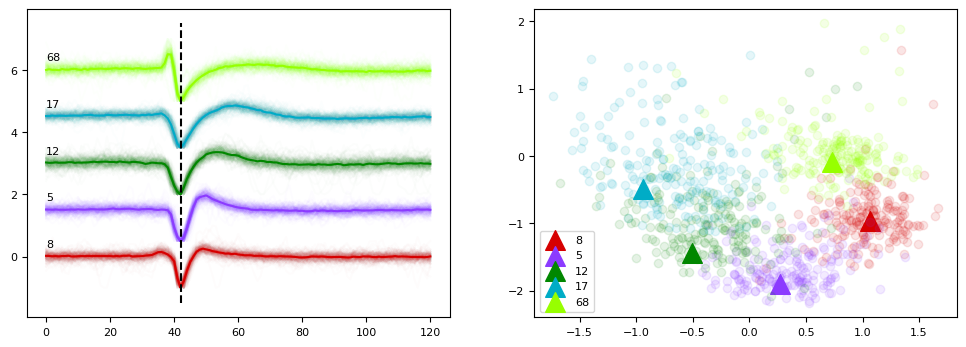

In [5]:
embeddings = fc_pca_ceed_emb

fig, axes = plt.subplots(1,2, figsize=(12,4))
unit_ids = [8,5,12,17,68]
colors = cc.glasbey[:len(unit_ids)]
vertical_offset = 0
for i, unit_id in enumerate(unit_ids):
    unit_ceed_emb = embeddings[labels_nonzero==unit_id]
    unit_spikes = spikes_nonzero[labels_nonzero==unit_id]
    template = np.median(unit_spikes,0)
    template_emb = fc_celltype_ceed_5d.transform(torch.from_numpy(template).float()[None,None,:])
    pc_template_emb = fc_pca_ceed.transform(template_emb[:,None].T)[0]
    axes[0].plot(unit_spikes.T + vertical_offset, color=colors[i], alpha=.01);
    axes[0].plot(template.T + vertical_offset, color=colors[i], alpha=1);
    axes[0].annotate(str(unit_id), xy=(0,vertical_offset+.3))
    vertical_offset += 1.5
    axes[1].scatter(unit_ceed_emb[:,0], unit_ceed_emb[:,1], color=colors[i], alpha=.1)
    axes[1].scatter(pc_template_emb[0], pc_template_emb[1], color=colors[i], alpha=1,marker="^", s=200, label=str(unit_id))
axes[0].vlines([42], ymax=vertical_offset, ymin= -1.5, ls='--', color='black')
plt.legend();

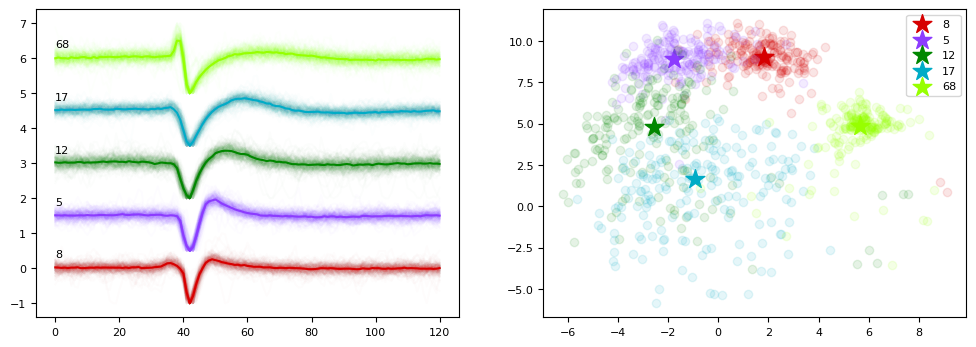

In [6]:
embeddings = fc_umap_ceed_emb

fig, axes = plt.subplots(1,2, figsize=(12,4))
unit_ids = [8,5,12,17,68]
colors = cc.glasbey[:len(unit_ids)]
vertical_offset = 0
for i, unit_id in enumerate(unit_ids):
    unit_ceed_emb = embeddings[labels_nonzero==unit_id]
    unit_spikes = spikes_nonzero[labels_nonzero==unit_id]
    template = np.median(unit_spikes,0)
    template_emb = fc_celltype_ceed_5d.transform(torch.from_numpy(template).float()[None,None,:])
    pc_template_emb = fc_pca_ceed.transform(template_emb[:,None].T)[0]
    axes[0].plot(unit_spikes.T + vertical_offset, color=colors[i], alpha=.01);
    axes[0].plot(template.T + vertical_offset, color=colors[i], alpha=1);
    axes[0].annotate(str(unit_id), xy=(0,vertical_offset+.3))
    vertical_offset += 1.5
    axes[1].scatter(unit_ceed_emb[:,0], unit_ceed_emb[:,1], color=colors[i], alpha=.1)
    #plot median of umap here because didn't do projection of template
    axes[1].scatter(np.median(unit_ceed_emb,0)[0], np.median(unit_ceed_emb,0)[1], color=colors[i], alpha=1,marker='*', s=200, label=str(unit_id))
plt.legend();

### Transform without a data folder

In [7]:
# same output as two cells above, but takes in actual data
cell_type_inference_data = np.load(os.path.join(celltype_test_data, 'spikes_test.npy'))
print("cell type data:", cell_type_inference_data.shape)
transformed_inference_data = fc_celltype_ceed_5d.transform(cell_type_inference_data)
print(transformed_inference_data.shape)

(80000, 5)
